1) Числовые признаки - заполняются средним значением. Категориальные признаки - заполняются наиболее частыми значениями и кодируются OneHotEncoder. В качестве линейной регрессии был выбран Ridge т.к на этот момент он давал лучший результат.

In [20]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, GridSearchCV

train_df = pd.read_csv('../house_prices/train_hw.csv')
test_df = pd.read_csv('../house_prices/test_hw.csv')

y = np.log1p(train_df['SalePrice'])
X_train = train_df.drop(columns=['SalePrice'])
X_test = test_df.copy()

combined = pd.concat([X_train, X_test], sort=False)

numeric_features = combined.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = combined.select_dtypes(include=['object']).columns.tolist()

print(f"Числовых признаков: {len(numeric_features)}, категориальных: {len(categorical_features)}")

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean'))
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Ridge())
])

param_grid = {'regressor__alpha': np.logspace(-5, 5, 11)}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_root_mean_squared_error')

grid_search.fit(X_train, y)

best_alpha = grid_search.best_params_['regressor__alpha']
print(f"Лучший alpha: {best_alpha}")

ridge_best = Ridge(alpha=best_alpha)
pipeline_ridge = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', ridge_best)
])

pipeline_ridge.fit(X_train, y)

ridge_scores = cross_val_score(pipeline_ridge, X_train, y, cv=5, scoring='neg_root_mean_squared_error')
print(f'Средний RMSE: {-ridge_scores.mean()}')

predictions = np.expm1(pipeline_ridge.predict(X_test))
predictions = np.round(predictions).astype(int)

submission = pd.DataFrame({
    'Id': test_df['Id'],
    'SalePrice': predictions
})

submission.to_csv('submission.csv', index=False)
print("Файл submission.csv успешно создан!")

Числовых признаков: 37, категориальных: 43
Лучший alpha: 0.001
Средний RMSE: 0.15878152688219863
Файл submission.csv успешно создан!


2) Был добавлен StandardScaler() для числовых признаков, Теперь числовые признаки переводятся к стандартному распределению со средним 0 и стандартным отклонением 1. Юыл пересмотрен перебор alpha. Была пересмотрена проверка RMSE.

In [21]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

train_df = pd.read_csv('../house_prices/train_hw.csv')
test_df = pd.read_csv('../house_prices/test_hw.csv')

y = np.log1p(train_df['SalePrice'])
X_train = train_df.drop(columns=['SalePrice'])
X_test = test_df.copy()

numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()

print(f"Числовых признаков: {len(numeric_features)}, категориальных: {len(categorical_features)}")

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

pipeline_ridge = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Ridge())
])

X_transformed = preprocessor.fit_transform(X_train)

param_grid = {'regressor__alpha': [0.1, 1, 5, 10, 20, 50]}

grid_search = GridSearchCV(pipeline_ridge, param_grid, cv=5, scoring='neg_mean_squared_error', error_score=np.nan)
grid_search.fit(X_train, y)

print(f"Лучший alpha: {grid_search.best_params_['regressor__alpha']}")
print(f"Лучший RMSE: {np.sqrt(-grid_search.best_score_)}")

predictions = np.expm1(grid_search.best_estimator_.predict(X_test))
predictions = np.round(predictions).astype(int)

submission = pd.DataFrame({
    'Id': test_df['Id'],
    'SalePrice': predictions
})

submission.to_csv('submission.csv', index=False)
print("Файл submission.csv создан!")

Числовых признаков: 37, категориальных: 43
Лучший alpha: 10
Лучший RMSE: 0.15187016136846182
Файл submission.csv создан!


3) Вернулся к старому перебору alpha. Добавлено удаление выбросов для LotArea при помощи метода межквартильного размаха. Добавлен PolynomialFeatures для числовых признаков, он создаёт новые признаки, которые представляют собой попарные взаимодействия между исходными числовыми признаками. Для OneHotEncoder добавлен параметр min_frequency=0.01, который автоматически объединяет редкие категории (встречающиеся менее чем в 1% строк) в одну, что в свою очередь уменьшает размерность данных и снижает переобучение из-за редких категорий.

In [22]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

train_df = pd.read_csv('../house_prices/train_hw.csv')
test_df = pd.read_csv('../house_prices/test_hw.csv')

Q1 = train_df['LotArea'].quantile(0.25)
Q3 = train_df['LotArea'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

train_df = train_df[(train_df['LotArea'] >= lower_bound) & (train_df['LotArea'] <= upper_bound)]

y = np.log1p(train_df['SalePrice'])
X_train = train_df.drop(columns=['SalePrice'])
X_test = test_df.copy()

numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()

print(f"Числовых признаков: {len(numeric_features)}, категориальных: {len(categorical_features)}")

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('poly', PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False, min_frequency=0.01))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

pipeline_ridge = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Ridge())
])

X_transformed = preprocessor.fit_transform(X_train)

param_grid = {
    'regressor__alpha': np.logspace(-3, 3, 10)
}

grid_search = GridSearchCV(pipeline_ridge, param_grid, cv=5, scoring='neg_mean_squared_error', error_score=np.nan)
grid_search.fit(X_train, y)

print(f"Лучший alpha: {grid_search.best_params_['regressor__alpha']}")
print(f"Лучший RMSE: {np.sqrt(-grid_search.best_score_)}")

predictions = np.expm1(grid_search.best_estimator_.predict(X_test))
predictions = np.round(predictions).astype(int)

submission = pd.DataFrame({
    'Id': test_df['Id'],
    'SalePrice': predictions
})

submission.to_csv('submission.csv', index=False)
print("Файл submission.csv создан!")

Числовых признаков: 37, категориальных: 43
Лучший alpha: 215.44346900318823
Лучший RMSE: 0.13371372782334806
Файл submission.csv создан!


4) Поменял перебор alpha: теперь используется np.logspace(-4, 4, 20) вместо np.logspace(-3, 3, 10). Добавлено удаление выбросов с помощью метода межквартильного размаха не только для LotArea, но и для OverallQual и GrLivArea. Изменена стратегия заполнения пропусков в числовых признаках с "mean" на "median", что повышает устойчивость к выбросам. Добавлен перебор степени PolynomialFeatures (1 и 2) в GridSearch, что позволяет модели автоматически выбирать необходимость включения взаимодействий между признаками. Для OneHotEncoder добавлен параметр max_categories=10, который ограничивает количество создаваемых категориальных признаков и помогает снизить переобучение.

In [23]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

train_df = pd.read_csv('../house_prices/train_hw.csv')
test_df = pd.read_csv('../house_prices/test_hw.csv')

def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    return df[(df[column] >= Q1 - 1.5 * IQR) & (df[column] <= Q3 + 1.5 * IQR)]

for col in ['LotArea', 'OverallQual', 'GrLivArea']:
    train_df = remove_outliers(train_df, col)

y = np.log1p(train_df['SalePrice'])
X_train = train_df.drop(columns=['SalePrice'])
X_test = test_df.copy()

numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()

print(f"Числовых признаков: {len(numeric_features)}, категориальных: {len(categorical_features)}")

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('poly', PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False, min_frequency=0.01, max_categories=10))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

pipeline_ridge = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Ridge())
])

param_grid = {
    'regressor__alpha': np.logspace(-4, 4, 20),
    'preprocessor__num__poly__degree': [1, 2]
}

grid_search = GridSearchCV(pipeline_ridge, param_grid, cv=5, scoring='neg_mean_squared_error', error_score=np.nan)
grid_search.fit(X_train, y)

print(f"Лучший alpha: {grid_search.best_params_['regressor__alpha']}")
print(f"Лучший RMSE: {np.sqrt(-grid_search.best_score_)}")

predictions = np.expm1(grid_search.best_estimator_.predict(X_test))
predictions = np.round(predictions).astype(int)

submission = pd.DataFrame({'Id': test_df['Id'], 'SalePrice': predictions})
submission.to_csv('submission.csv', index=False)
print("Файл submission.csv создан!")

Числовых признаков: 37, категориальных: 43
Лучший alpha: 11.288378916846883
Лучший RMSE: 0.11488473212114447
Файл submission.csv создан!


5) Добавлено удаление выбросов по новым признакам: GrLivArea, 1stFlrSF, YearRemodAdd, YearBuilt и GarageYrBlt, с более мягким порогом — верхняя граница задаётся как 2.5 IQR. Также удаляются выбросы по SalePrice с ещё более мягким порогом (3 IQR), что помогает убрать выбросы. Добавлено удаление признаков с более чем 70% пропусковю. Добавлен параметр preprocessor__num__poly__interaction_only у PolynomialFeatures, что позволяет выбирать между взаимодействиями и квадратичными эффектами. Удалён параметр max_categories из OneHotEncoder.

In [24]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

train_df = pd.read_csv('../house_prices/train_hw.csv')
test_df = pd.read_csv('../house_prices/test_hw.csv')

def remove_outliers(df, column, lower_factor=1.5, upper_factor=1.5):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_limit = Q1 - lower_factor * IQR
    upper_limit = Q3 + upper_factor * IQR
    return df[(df[column] >= lower_limit) & (df[column] <= upper_limit)]

for col in ['GrLivArea', '1stFlrSF', 'YearRemodAdd', 'YearBuilt', 'GarageYrBlt']:
    train_df = remove_outliers(train_df, col, upper_factor=2.5)

train_df = remove_outliers(train_df, 'SalePrice', upper_factor=3)

y = np.log1p(train_df['SalePrice'])
X_train = train_df.drop(columns=['SalePrice'])
X_test = test_df.copy()

X_train = X_train.drop(columns=[col for col in X_train.columns if X_train[col].isnull().mean() > 0.7])
X_test = X_test[X_train.columns]

numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()

print(f"Числовых признаков: {len(numeric_features)}, категориальных: {len(categorical_features)}")

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('poly', PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False, min_frequency=0.01))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Ridge())
])

param_grid = {
    'regressor__alpha': np.logspace(-4, 4, 20),
    'preprocessor__num__poly__degree': [1, 2],
    'preprocessor__num__poly__interaction_only': [True, False]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', error_score=np.nan)
grid_search.fit(X_train, y)

print(f"Лучший alpha: {grid_search.best_params_['regressor__alpha']}")
print(f"Лучший RMSE: {np.sqrt(-grid_search.best_score_)}")

predictions = np.expm1(grid_search.best_estimator_.predict(X_test))
predictions = np.round(predictions).astype(int)

submission = pd.DataFrame({'Id': test_df['Id'], 'SalePrice': predictions})
submission.to_csv('submission.csv', index=False)
print("Файл submission.csv создан!")

Числовых признаков: 37, категориальных: 39
Лучший alpha: 11.288378916846883
Лучший RMSE: 0.11183460493389176
Файл submission.csv создан!


6) Произведена небольшая коррекция параметров метода межквартильного размаха. Отказался от использования PolynomialFeatures, так как добавление новых признаков не улучшало результаты модели, а лишь увеличивало время выполнения. Вместо StandardScaler стал использовать RobustScaler, что должно делать модель более устойчивой к выбросам.

In [25]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

train_df = pd.read_csv('../house_prices/train_hw.csv')
test_df = pd.read_csv('../house_prices/test_hw.csv')

def remove_outliers(df, column, lower_factor=1.25, upper_factor=1.25):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_limit = Q1 - lower_factor * IQR
    upper_limit = Q3 + upper_factor * IQR
    return df[(df[column] >= lower_limit) & (df[column] <= upper_limit)]

for col in ['GrLivArea', '1stFlrSF', 'YearRemodAdd', 'YearBuilt', 'GarageYrBlt']:
    train_df = remove_outliers(train_df, col, upper_factor=2.5)

train_df = remove_outliers(train_df, 'SalePrice', upper_factor=3)

y = np.log1p(train_df['SalePrice'])
X_train = train_df.drop(columns=['SalePrice'])
X_test = test_df.copy()

X_train = X_train.drop(columns=[col for col in X_train.columns if X_train[col].isnull().mean() > 0.7])
X_test = X_test[X_train.columns]

numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()

print(f"Числовых признаков: {len(numeric_features)}, категориальных: {len(categorical_features)}")

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler()),
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False, min_frequency=0.01))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Ridge())
])

param_grid = {'regressor__alpha': np.logspace(-4, 4, 20),}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', error_score=np.nan)
grid_search.fit(X_train, y)

print(f"Лучший alpha: {grid_search.best_params_['regressor__alpha']}")
print(f"Лучший RMSE: {np.sqrt(-grid_search.best_score_)}")

predictions = np.expm1(grid_search.best_estimator_.predict(X_test))
predictions = np.round(predictions).astype(int)

submission = pd.DataFrame({'Id': test_df['Id'], 'SalePrice': predictions})
submission.to_csv('submission.csv', index=False)
print("Файл submission.csv создан!")

Числовых признаков: 37, категориальных: 39
Лучший alpha: 11.288378916846883
Лучший RMSE: 0.11034559792883317
Файл submission.csv создан!


7) Снова небольшая коррекция параметров метода межквартильного размаха. Добавлена обработка признаков с сильной асимметрией (log-преобразование), это должно помочь улучшить нормальное (симметричное) распределение.

In [26]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from scipy.stats import skew

train_df = pd.read_csv('../house_prices/train_hw.csv')
test_df = pd.read_csv('../house_prices/test_hw.csv')

def remove_outliers(df, column, lower_factor=1, upper_factor=1.25):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_limit = Q1 - lower_factor * IQR
    upper_limit = Q3 + upper_factor * IQR
    return df[(df[column] >= lower_limit) & (df[column] <= upper_limit)]

for col in ['GrLivArea', '1stFlrSF', 'YearRemodAdd', 'YearBuilt', 'GarageYrBlt']:
    train_df = remove_outliers(train_df, col, upper_factor=1.5)
train_df = remove_outliers(train_df, 'SalePrice', upper_factor=3)

y = np.log1p(train_df['SalePrice'])

X_train = train_df.drop(columns=['SalePrice'])
X_train = X_train.drop(columns=[col for col in X_train.columns if X_train[col].isnull().mean() > 0.7])
X_test = test_df[X_train.columns].copy()

numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()

print(f"Числовых признаков: {len(numeric_features)}, категориальных: {len(categorical_features)}")

skew_thresh = 1
skewed_feats = X_train[numeric_features].apply(lambda x: skew(x.dropna()))
skewed_feats = skewed_feats[skewed_feats > skew_thresh].index.tolist()

for feat in skewed_feats:
    if (X_train[feat] > 0).all():
        X_train[feat] = np.log1p(X_train[feat])
        X_test[feat] = np.log1p(X_test[feat])

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler()),
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False, min_frequency=0.005))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Ridge())
])

param_grid = {'regressor__alpha': np.logspace(-4, 4, 20),}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', error_score=np.nan)
grid_search.fit(X_train, y)

print(f"Лучший alpha: {grid_search.best_params_['regressor__alpha']}")
print(f"Лучший RMSE: {np.sqrt(-grid_search.best_score_)}")

predictions = np.expm1(grid_search.best_estimator_.predict(X_test))
predictions = np.round(predictions).astype(int)

submission = pd.DataFrame({'Id': test_df['Id'], 'SalePrice': predictions})
submission.to_csv('submission.csv', index=False)
print("Файл submission.csv создан!")

Числовых признаков: 37, категориальных: 39
Лучший alpha: 11.288378916846883
Лучший RMSE: 0.1027773718714049
Файл submission.csv создан!


8) Модель Ridge заменена на ElasticNet которая комбинирует L1 (как Lasso) и L2 (как Ridge). Так же были изменены параметры метода межквартильного размаха и log-преобразования.

In [29]:
import pandas as pd
import numpy as np
from sklearn.linear_model import ElasticNet
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from scipy.stats import skew

train_df = pd.read_csv('../house_prices/train_hw.csv')
test_df = pd.read_csv('../house_prices/test_hw.csv')

def remove_outliers(df, column, lower_factor=1, upper_factor=1.5):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_limit = Q1 - lower_factor * IQR
    upper_limit = Q3 + upper_factor * IQR
    return df[(df[column] >= lower_limit) & (df[column] <= upper_limit)]

for col in ['GrLivArea', '1stFlrSF', 'YearRemodAdd', 'YearBuilt', 'GarageYrBlt']:
    train_df = remove_outliers(train_df, col, upper_factor=1.2)
train_df = remove_outliers(train_df, 'SalePrice', upper_factor=2)

y = np.log1p(train_df['SalePrice'])

X_train = train_df.drop(columns=['SalePrice'])
X_train = X_train.drop(columns=[col for col in X_train.columns if X_train[col].isnull().mean() > 0.7])
X_test = test_df[X_train.columns].copy()

numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()

skew_thresh = 0.75
skewed_feats = X_train[numeric_features].apply(lambda x: skew(x.dropna()))
skewed_feats = skewed_feats[skewed_feats > skew_thresh].index.tolist()

for feat in skewed_feats:
    if (X_train[feat] > 0).all():
        X_train[feat] = np.log1p(X_train[feat])
        X_test[feat] = np.log1p(X_test[feat])

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler()),
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False, min_frequency=0.005))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', ElasticNet(max_iter=15000))
])

param_grid = {
    'regressor__alpha': np.logspace(-4, 4, 20),
    'regressor__l1_ratio': [0.1, 0.5, 0.9],
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', error_score=np.nan)
grid_search.fit(X_train, y)

print(f"Лучший alpha: {grid_search.best_params_['regressor__alpha']}")
print(f"Лучший RMSE: {np.sqrt(-grid_search.best_score_)}")

predictions = np.expm1(grid_search.best_estimator_.predict(X_test))
predictions = np.round(predictions).astype(int)

submission = pd.DataFrame({'Id': test_df['Id'], 'SalePrice': predictions})
submission.to_csv('submission.csv', index=False)
print("Файл submission.csv создан!")

Лучший alpha: 0.004832930238571752
Лучший RMSE: 0.09764223792722965
Файл submission.csv создан!


9) Данная часть так же улучшалась на протяжении всей работы, но я не стал её подробно описывать. Её основная задача - дать возможность посмотреть от каких признаков больше всего зависит SalePrice, посмотреть на выбросы и как это можно поправить.

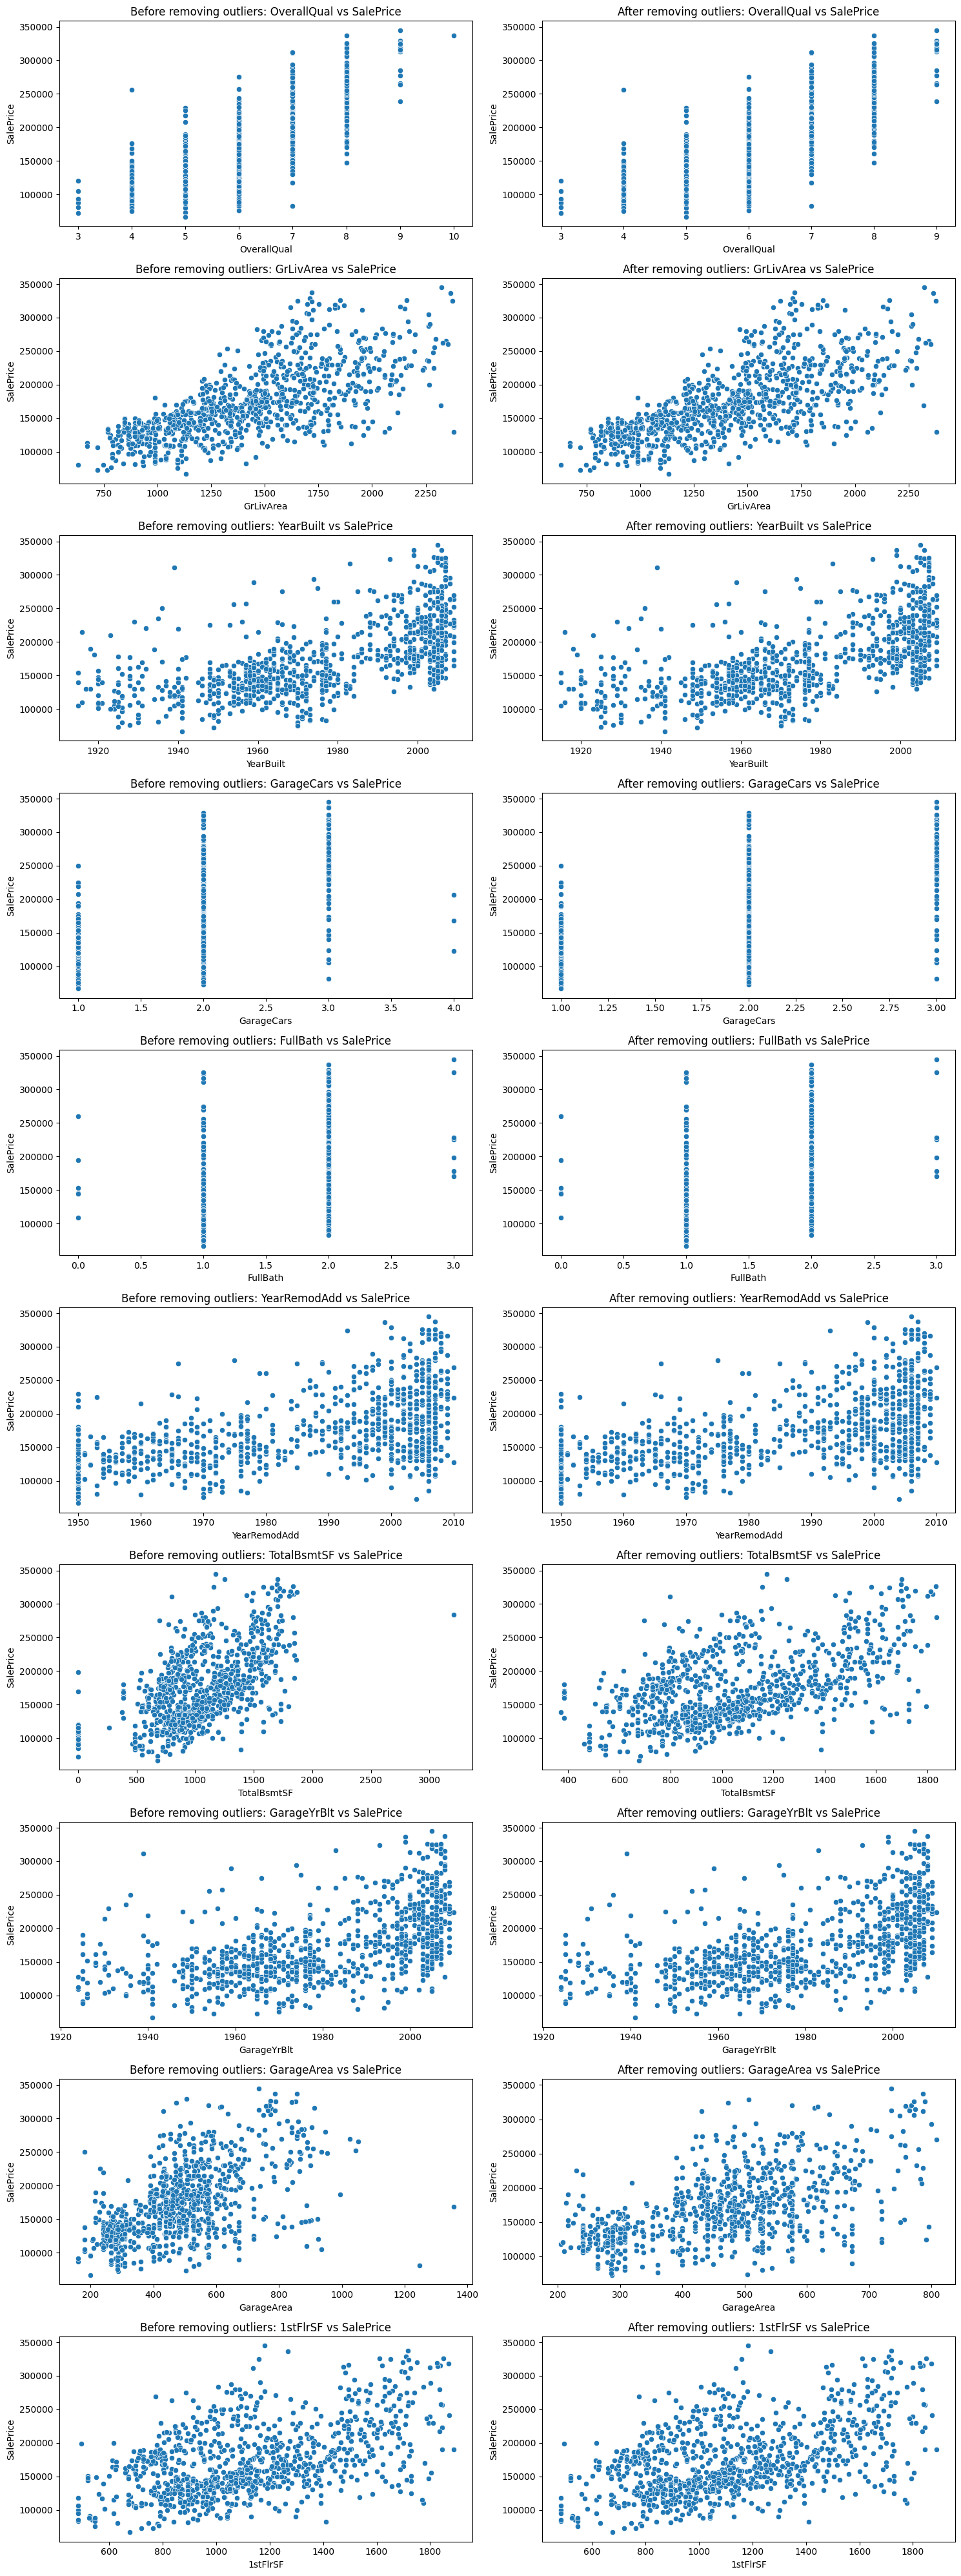

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

def remove_outliers(df, column, lower_factor=1, upper_factor=1.25):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_limit = Q1 - lower_factor * IQR
    upper_limit = Q3 + upper_factor * IQR
    return df[(df[column] >= lower_limit) & (df[column] <= upper_limit)]

for col in ['GrLivArea', '1stFlrSF', 'YearRemodAdd', 'YearBuilt', 'GarageYrBlt']:
    train_df = remove_outliers(train_df, col, upper_factor=1.2)

train_df = remove_outliers(train_df, 'SalePrice', upper_factor=2)

numeric_df = train_df.select_dtypes(include=['int64', 'float64'])

correlation = numeric_df.corr()['SalePrice'].abs().sort_values(ascending=False)

top_features = correlation.index[1:11]

plt.figure(figsize=(15, 40))
for i, feature in enumerate(top_features, 1):
    plt.subplot(10, 2, 2 * i - 1)
    sns.scatterplot(x=train_df[feature], y=train_df['SalePrice'])
    plt.xlabel(feature)
    plt.ylabel('SalePrice')
    plt.title(f'Before removing outliers: {feature} vs SalePrice')
    
    filtered_df = remove_outliers(train_df, feature)
    plt.subplot(10, 2, 2 * i)
    sns.scatterplot(x=filtered_df[feature], y=filtered_df['SalePrice'])
    plt.xlabel(feature)
    plt.ylabel('SalePrice')
    plt.title(f'After removing outliers: {feature} vs SalePrice')

plt.tight_layout()
plt.show()